# imports

In [1]:
from torch import nn
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal
from mnist_example.data import *
from mnist_example.losses import *
from mnist_example.qlvm import *
from mnist_example.train import *
import matplotlib.pyplot as plt
import os

from torch.autograd.functional import jacobian
from torch.func import jacfwd,vmap,jacrev

from scipy import ndimage

## helper functions for jacobians

# load data

In [3]:
max_workers=16
batch_size=128
dataloc = './'
train_loader,test_loader = load_mnist(dataloc,max_workers,batch_size)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

loading mnist...


# make and train qlvm

In [4]:
qlvm_loss =binary_evidence

qlvm = get_qlvm(device)
qmc_lattice = gen_fib_basis(m=15)
qlvm,qlvm_opt,qlvm_losses = train_loop(qlvm,train_loader,qmc_lattice.to(qlvm.device),qlvm_loss,nEpochs=50)
qlvm_test_loss = test_epoch(qlvm,test_loader,qmc_lattice.to(qlvm.device),qlvm_loss)

Epoch 1 Average loss: 1.3085
Epoch 2 Average loss: 1.1358
Epoch 3 Average loss: 1.1082
Epoch 4 Average loss: 1.0880
Epoch 5 Average loss: 1.0732
Epoch 6 Average loss: 1.0626
Epoch 7 Average loss: 1.0546
Epoch 8 Average loss: 1.0482
Epoch 9 Average loss: 1.0429
Epoch 10 Average loss: 1.0384
Epoch 11 Average loss: 1.0349
Epoch 12 Average loss: 1.0315
Epoch 13 Average loss: 1.0287
Epoch 14 Average loss: 1.0262
Epoch 15 Average loss: 1.0238
Epoch 16 Average loss: 1.0217
Epoch 17 Average loss: 1.0195
Epoch 18 Average loss: 1.0177
Epoch 19 Average loss: 1.0158
Epoch 20 Average loss: 1.0143
Epoch 21 Average loss: 1.0127
Epoch 22 Average loss: 1.0111
Epoch 23 Average loss: 1.0097
Epoch 24 Average loss: 1.0083
Epoch 25 Average loss: 1.0069
Epoch 26 Average loss: 1.0058
Epoch 27 Average loss: 1.0045
Epoch 28 Average loss: 1.0034
Epoch 29 Average loss: 1.0024
Epoch 30 Average loss: 1.0012
Epoch 31 Average loss: 1.0003
Epoch 32 Average loss: 0.9992
Epoch 33 Average loss: 0.9986
Epoch 34 Average lo

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 150.97it/s]


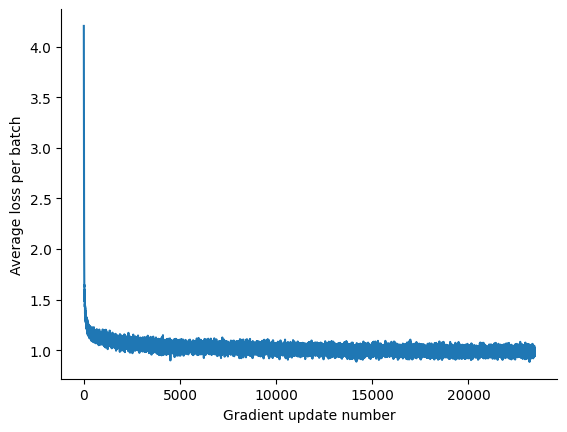

In [5]:
ax = plt.gca()
ax.plot(qlvm_losses/batch_size)
ax.set_xlabel("Gradient update number")
ax.set_ylabel("Average loss per batch")
ax.spines[['right','top']].set_visible(False)
plt.show()
plt.close()

# embed data

In [6]:
visualization_lattice = gen_fib_basis(m=20)

qlvm_lp = binary_lp

### embedding using weighted average over lattice
train_embeddings,train_labels = qlvm.embed_data(visualization_lattice,train_loader,qlvm_lp,embed_type='posterior')
test_embeddings,test_labels = qlvm.embed_data(visualization_lattice,test_loader,qlvm_lp,embed_type='posterior')
### embedding using argmax
#train_embeddings,train_labels = qlvm.embed_data(visualization_lattice,train_loader,qlvm_lp,embed_type='argmax')
#test_embeddings,test_labels = qlvm.embed_data(visualization_lattice,test_loader,qlvm_lp,embed_type='posterior')

### embedding using RQMC
#train_embeddings,train_labels = qlvm.embed_data(visualization_lattice,train_loader,qlvm_lp,embed_type='rqmc',n_samples=10)
#test_embeddings,test_labels = qlvm.embed_data(visualization_lattice,test_loader,qlvm_lp,embed_type='rqmc',n_samples=10)


embedding latents: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.98it/s]


In [7]:
import matplotlib as mpl
tab10 = mpl.colormaps['tab10']
norm = mpl.colors.BoundaryNorm(np.linspace(0,1,11), tab10.N, extend='neither')


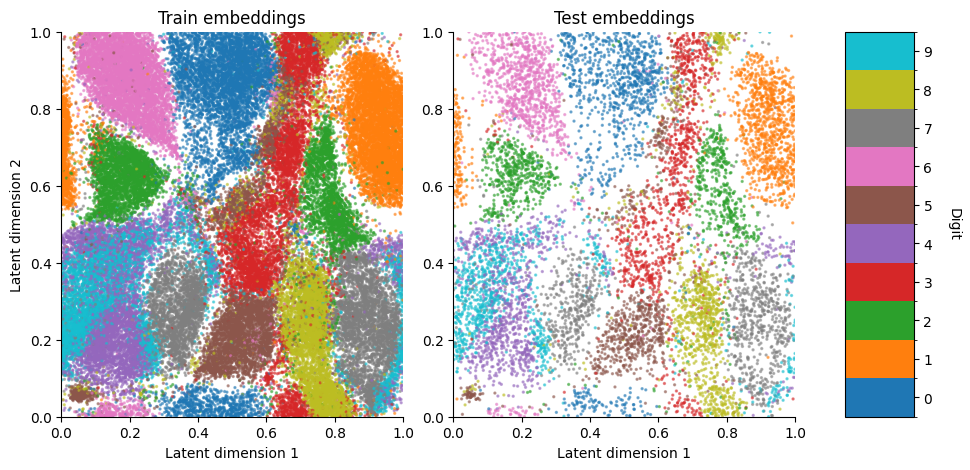

In [8]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(11,5),width_ratios=(5,5,1))
axs[0].scatter(train_embeddings[:,0],train_embeddings[:,1],c=train_labels/9,cmap='tab10',s=2,alpha=0.5,zorder=-1)
axs[1].scatter(test_embeddings[:,0],test_embeddings[:,1],c=test_labels/9,cmap='tab10',s=2,alpha=0.5,zorder=-1)
axs[0].set_title('Train embeddings')
axs[1].set_title('Test embeddings')
for ax in axs[:2]:
    ax.spines[['right','top']].set_visible(False)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel("Latent dimension 1")
    ax.set_rasterization_zorder(0)
axs[0].set_ylabel("Latent dimension 2")

cb =plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=tab10),
             cax=axs[2])
cb.set_label("Digit",rotation=270,labelpad=20)
curr_ticks = np.linspace(0,1,11)
pad = curr_ticks[1]/2
new_ticks = np.arange(pad,1,curr_ticks[1])
cb.set_ticks(new_ticks)
cb.set_ticklabels(np.arange(10))

plt.show()
plt.close()

# get aggregate posterior

In [9]:
visualization_lattice = gen_fib_basis(m=20).to(qlvm.device)

### only one option for getting aggregated posteriors: using the log probability of reconstructions
qlvm_lp = binary_lp

train_posterior = []
test_posterior = []

for batch,_ in tqdm(train_loader,total=len(train_loader)):
    
    batch = batch.to(qlvm.device)
    train_posterior.append(qlvm.posterior_probability(visualization_lattice,batch,qlvm_lp).detach().cpu().numpy())

train_aggregated_posterior = np.nanmean(np.vstack(train_posterior),axis=0)

for batch,_ in tqdm(test_loader,total=len(test_loader)):
    batch = batch.to(qlvm.device)
    test_posterior.append(qlvm.posterior_probability(visualization_lattice,batch,qlvm_lp).detach().cpu().numpy())

test_aggregated_posterior = np.nanmean(np.vstack(test_posterior),axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.81it/s]


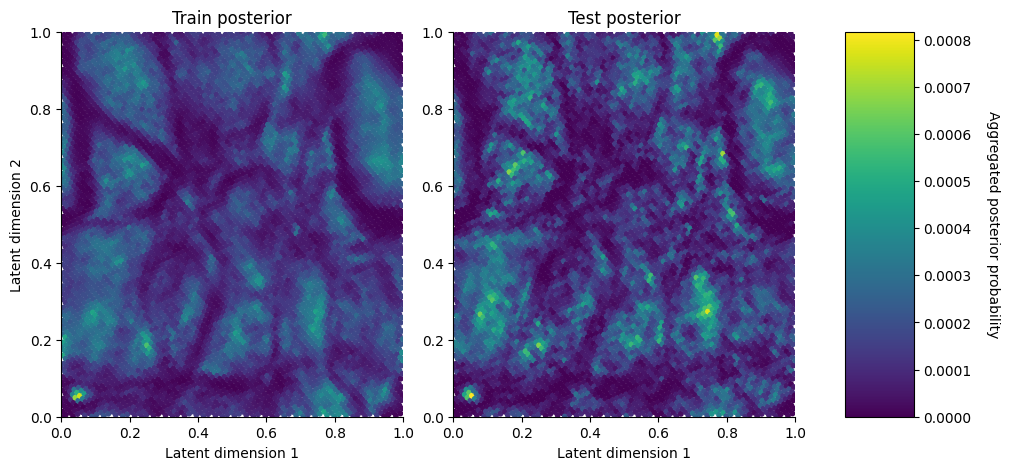

In [10]:
vmax = max(np.amax(train_aggregated_posterior),np.amax(test_aggregated_posterior))
plot_lattice = visualization_lattice.detach().cpu().numpy() % 1
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(11,5),width_ratios=(5,5,1))
g = axs[0].scatter(plot_lattice[:,0],plot_lattice[:,1],c=train_aggregated_posterior,
                   cmap='viridis',s=10,alpha=1,zorder=-1,vmin=0,vmax=vmax)
axs[1].scatter(plot_lattice[:,0],plot_lattice[:,1],c=test_aggregated_posterior,
               cmap='viridis',s=10,alpha=1,zorder=-1,vmin=0,vmax=vmax)
axs[0].set_title('Train posterior')
axs[1].set_title('Test posterior')
for ax in axs[:2]:
    ax.spines[['right','top']].set_visible(False)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel("Latent dimension 1")
    ax.set_rasterization_zorder(0)
axs[0].set_ylabel("Latent dimension 2")
cb =plt.colorbar(g,
             cax=axs[2])
cb.set_label("Aggregated posterior probability",rotation=270,labelpad=20)
plt.show()
plt.close()

# cluster on aggregate posterior

the only hyperparameter to tune is bandwidth, which helps determine how many clusters you'll find


As input, this function takes (in order):
- latent points: points to cluster. Here, I'm passing them through the cosine/sine basis before clustering `torus_forward(plot_lattice)`, because that way I can take advantage of faster numpy distance/sklearn functions
- seeds: putative cluster centers. These will be shifted around & fine-tuned to become cluster centers
- weights: weights on each latent point. These are necessary if you are going to do weighted mean-shift! and must be Nx1, where N is the number of points in `latent_points`
- bandwidth: hyperparameter to tune
- n_jobs: number of jobs to run clustering on. Treat similarly to n_workers in dataloaders for training
- p: p for `L_p` metric being used
- embedded: `True` or `False`; should be set to `True` if passing `plot_lattice` through `torus_forward`
- normal: `True` or `False`; should be set to `False` if performing weighted mean shift clustering 

In [11]:
from analysis.clustering import run_mean_shift
from analysis.model_helpers import torus_forward, torus_reverse


In [12]:
bws = [0.18,0.19,0.2,0.25,0.26,0.3]
ms_centers = []
ms_labels = []

train_lattice_m = 15
train_lattice = gen_fib_basis(m=train_lattice_m)
seeds = (train_lattice % 1).detach().cpu().numpy()
test_lattice = gen_fib_basis(m=20)
plot_lattice = (test_lattice % 1).detach().cpu().numpy()

for bw in bws:
    print(f"running mean-shift for bw = {bw}")
    centers,wms,labs = run_mean_shift(torus_forward(plot_lattice),torus_forward(seeds),train_aggregated_posterior[:,None],bandwidth=bw,n_jobs=16,p=2,embedded=True)
    
    print("done!")
    ms_centers.append(centers)

    
    ms_labels.append(labs)

running mean-shift for bw = 0.18
using L_p metrics
fitting weighted mean shift
running mean shift on 610 seeds
done!
predicting 6765 points
done!
done!
running mean-shift for bw = 0.19
using L_p metrics
fitting weighted mean shift
running mean shift on 610 seeds
done!
predicting 6765 points
done!
done!
running mean-shift for bw = 0.2
using L_p metrics
fitting weighted mean shift
running mean shift on 610 seeds
done!
predicting 6765 points
done!
done!
running mean-shift for bw = 0.25
using L_p metrics
fitting weighted mean shift
running mean shift on 610 seeds
done!
predicting 6765 points
done!
done!
running mean-shift for bw = 0.26
using L_p metrics
fitting weighted mean shift
running mean shift on 610 seeds
done!
predicting 6765 points
done!
done!
running mean-shift for bw = 0.3
using L_p metrics
fitting weighted mean shift
running mean shift on 610 seeds
done!
predicting 6765 points
done!
done!


In [86]:
import fastplotlib as fpl
import pygfx

In [ ]:
image = qlvm(torch.from_numpy(centers[0]).to("cuda"), random=False, mod=False).detach().cpu().numpy()

RFBOutputContext()

JupyterRenderCanvas(css_height='700.0px', css_width='1000.0px')
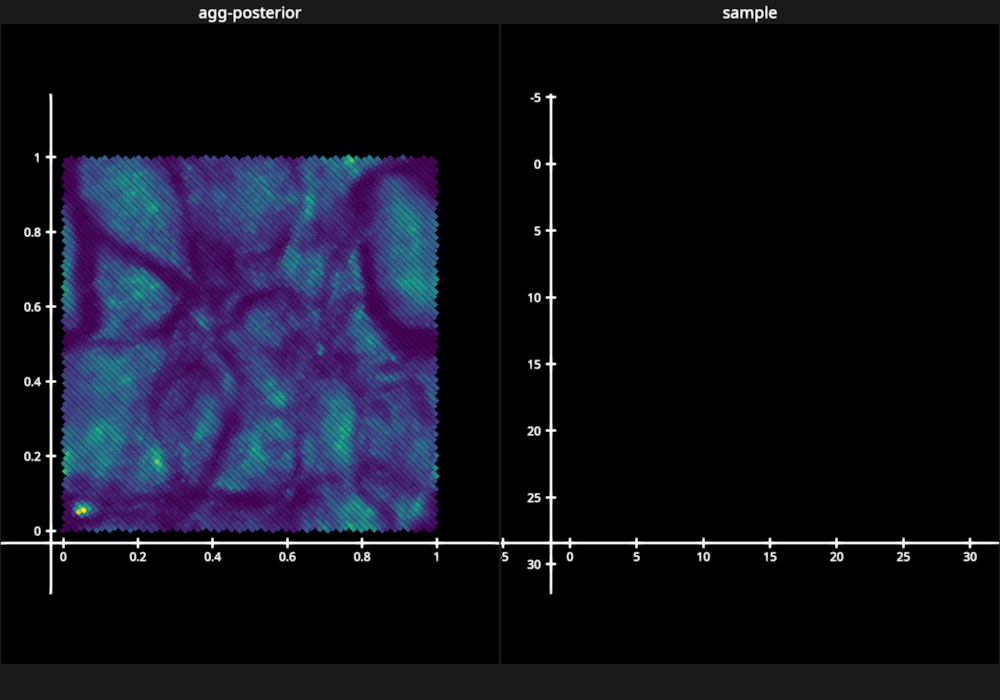

In [121]:
fig = fpl.Figure(shape=(1, 2), names=["agg-posterior", "sample"], size=(1000, 700))

x_density = np.diff(np.unique(np.sort(plot_lattice[:, 0]))).mean()
y_density = np.diff(np.unique(np.sort(plot_lattice[:, 1]))).mean()
density = np.mean([x_density, y_density])

scatter_posterior = fig["agg-posterior"].add_scatter(
    plot_lattice, 
    cmap="viridis", 
    cmap_transform=train_aggregated_posterior, 
    sizes=density * 100, 
    size_space="model",
    edge_width=0.001,
    edge_colors=(0, 0, 0, 0),
    uniform_edge_color=False,
    markers="D",
    # metadata=train_aggregated_posterior,
)

image = fig["sample"].add_image(np.zeros((28, 28)), cmap="grey", vmin=0, vmax=1)

last_index = 0
@scatter_posterior.add_event_handler("pointer_move")
def update_sample(ev: pygfx.PointerEvent):
    latent_pos = fig["agg-posterior"].map_screen_to_world(ev)[:-1].astype(np.float32)
    if latent_pos is None:
        return
        
    # global last_index
    # reset edge color
    # scatter_posterior.edge_colors[last_index] = (0, 0, 0, 0)

    # index = ev.pick_info["vertex_index"]
    # latent_pos = ev.graphic.data[index][:-1]
    
    # set edge color of new point
    # scatter_posterior.edge_colors[index] = "r"

    # set sample
    image.data = qlvm(torch.from_numpy(latent_pos).to("cuda"), random=False, mod=False).detach().cpu().numpy()

    # last_index = index


fig.show()

In [85]:
%%timeit
recon = qlvm(torch.from_numpy(centers[2]).to("cuda"), random=False, mod=False).detach()

135 μs ± 4.6 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


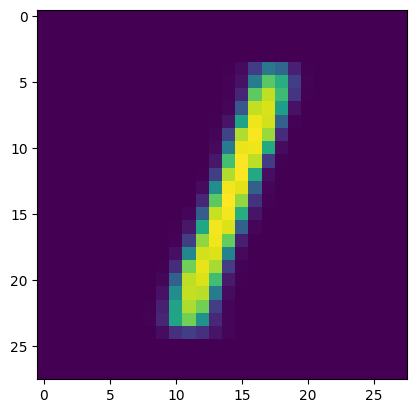

In [23]:
plt.imshow(recon.squeeze().cpu().numpy())

only plotting first 25 centroids


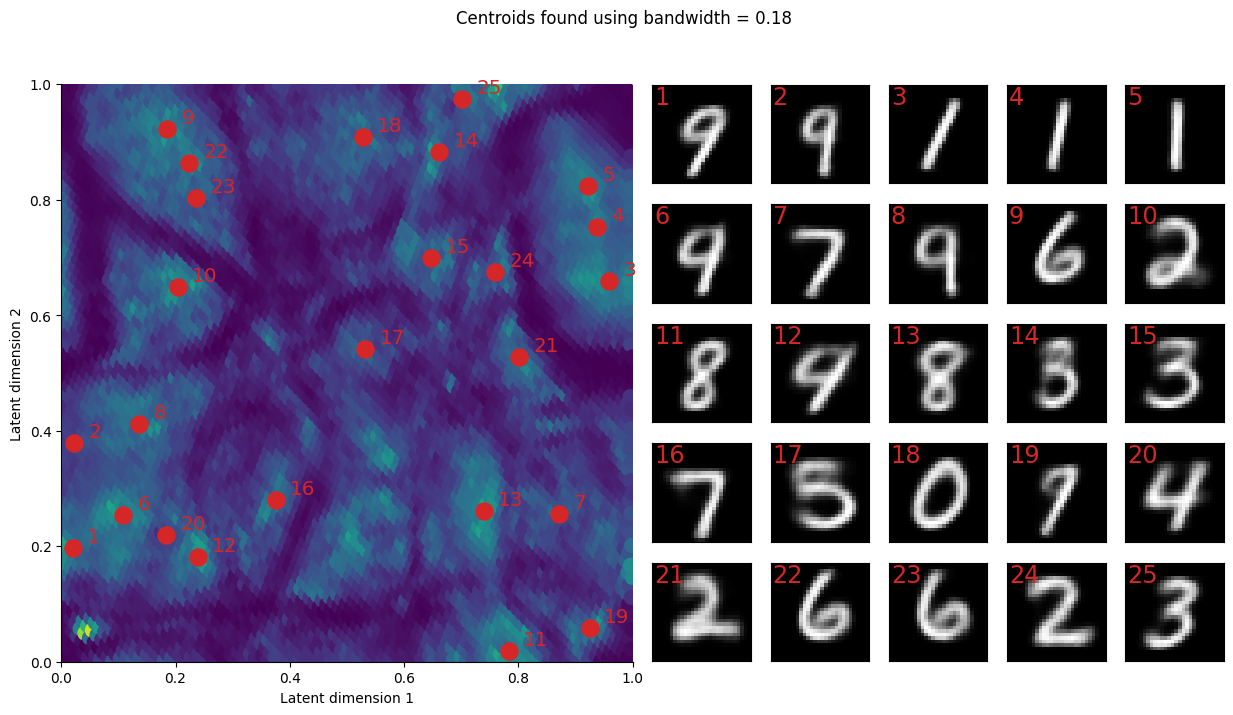

only plotting first 25 centroids


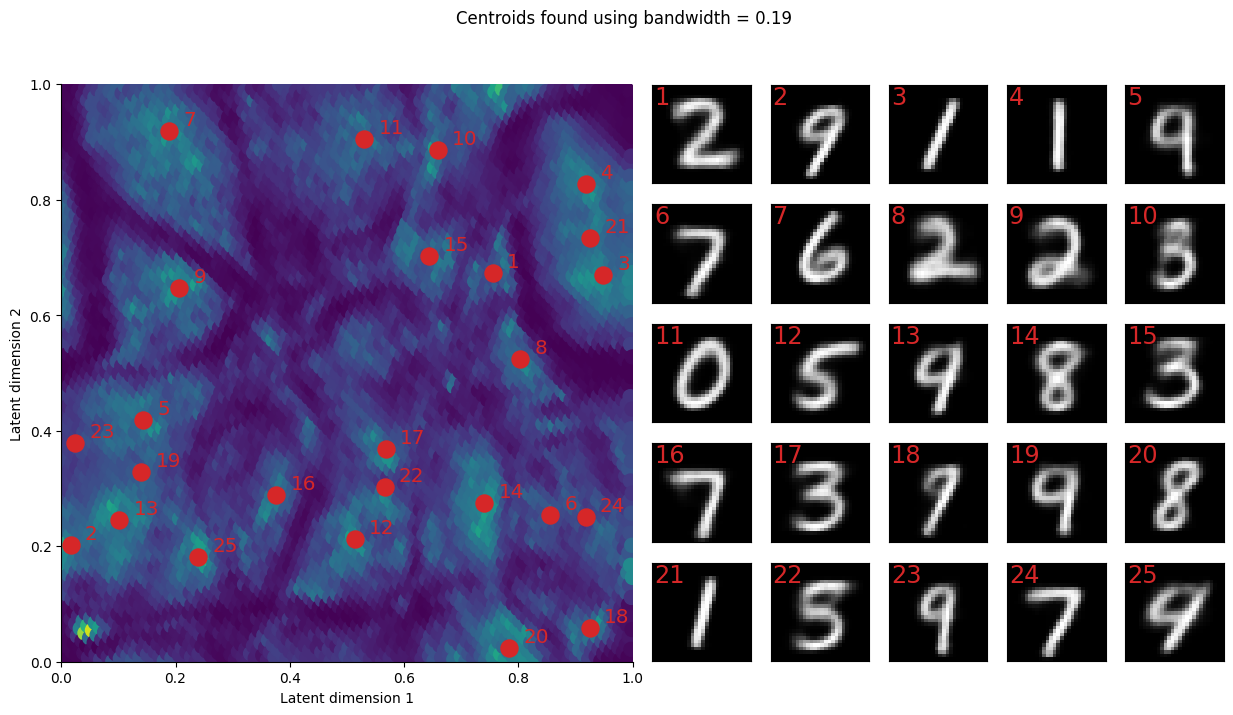

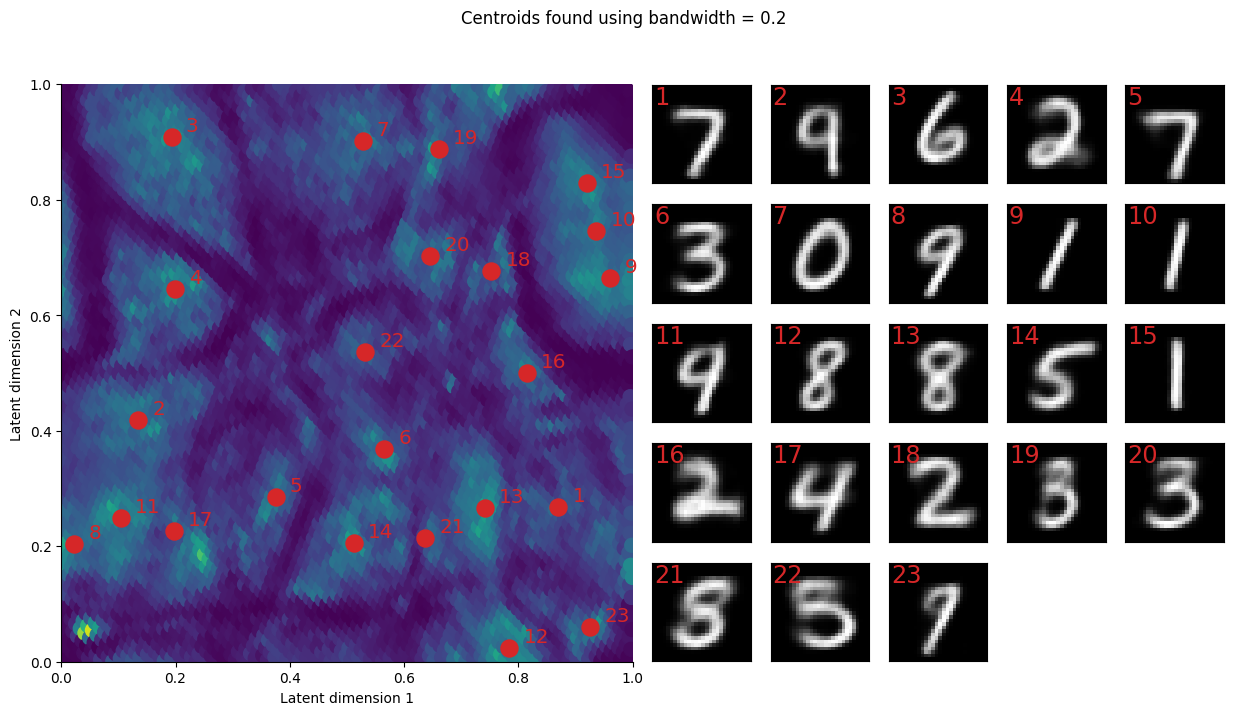

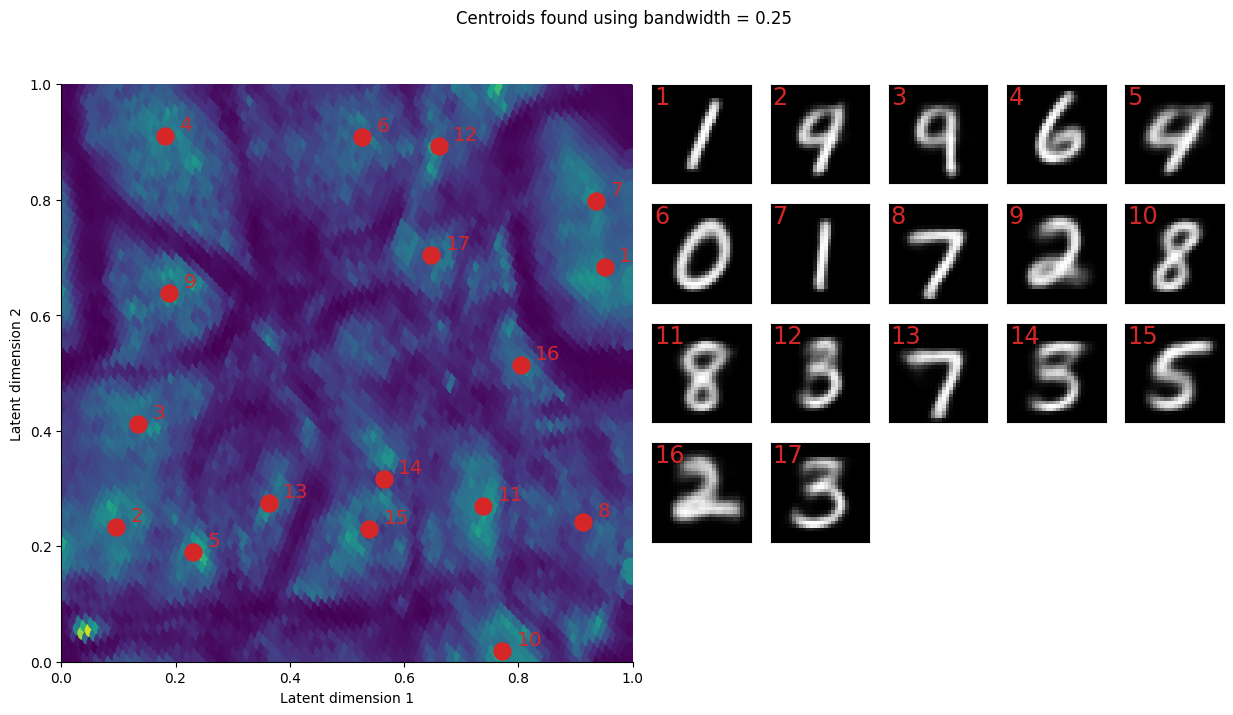

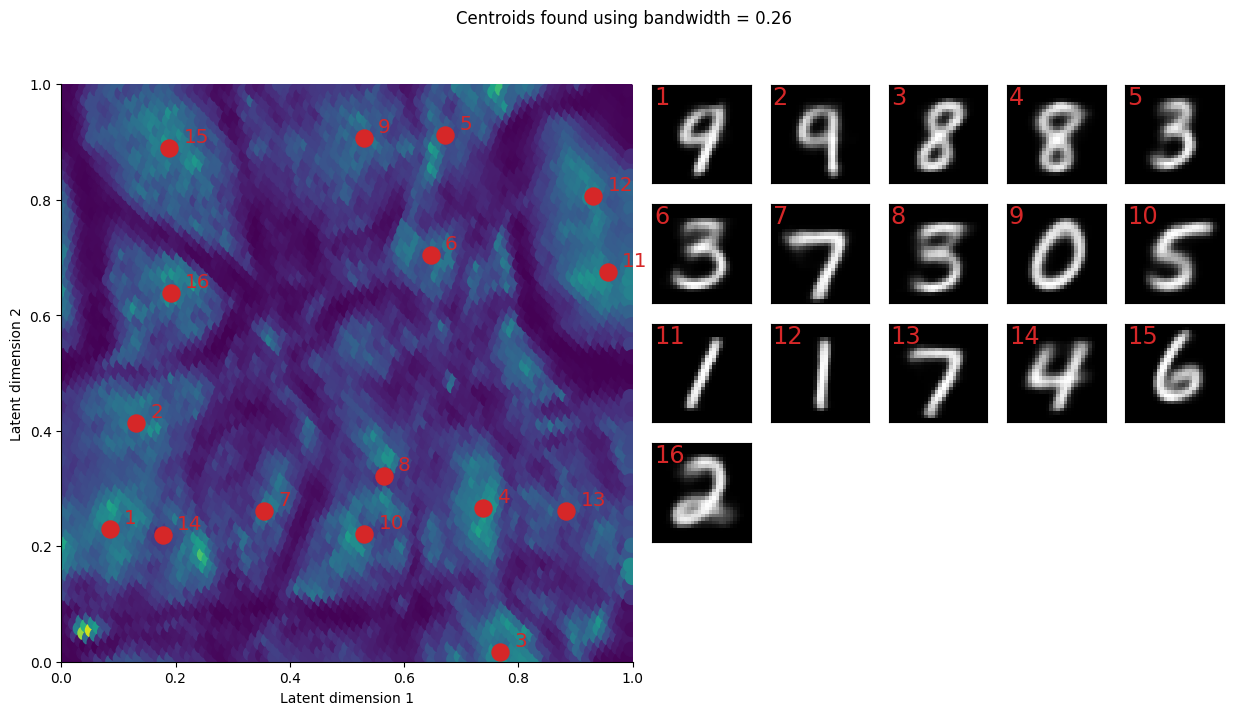

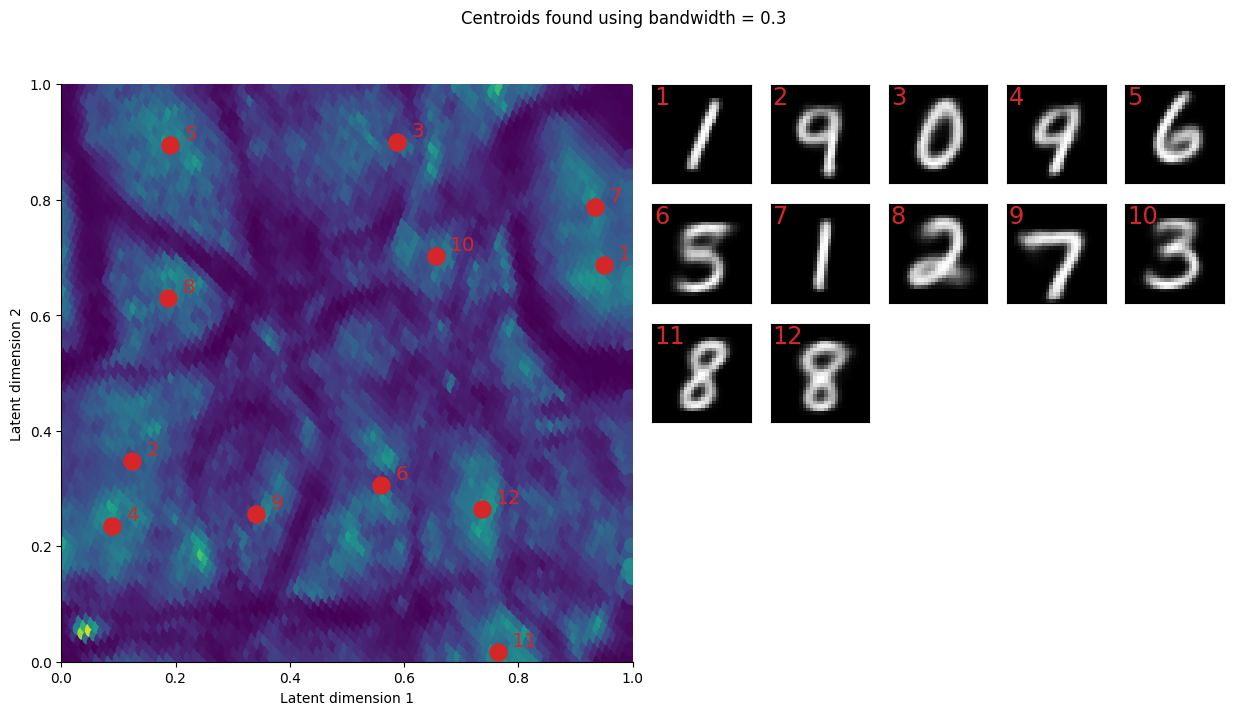

In [13]:
mosaic = [['posterior']*5 + [f"center {ii}" for ii in range(5)],
          ['posterior']*5 + [f"center {ii}" for ii in range(5,10)],
          ['posterior']*5 + [f"center {ii}" for ii in range(10,15)],
          ['posterior']*5 + [f"center {ii}" for ii in range(15,20)],
          ['posterior']*5 + [f"center {ii}" for ii in range(20,25)]]
                
for bw, centers,labels in zip(bws,ms_centers,ms_labels):
    #print(centers.shape)
    if centers.shape[0] > 25:
        print("only plotting first 25 centroids")

    fig,axs = plt.subplot_mosaic(mosaic,figsize=(15,7.5))
    axs['posterior'].scatter(plot_lattice[:,0],plot_lattice[:,1],
                             c=train_aggregated_posterior,cmap='viridis',
                             s=100,alpha=1,zorder=-1,vmin=0,vmax=vmax)
    axs['posterior'].scatter(centers[:25,0],centers[:25,1],color='tab:red',zorder=1,s=150)
    
    axs['posterior'].spines[['right','top']].set_visible(False)
    axs['posterior'].set_xlim((0,1))
    axs['posterior'].set_ylim((0,1))
    axs['posterior'].set_xlabel("Latent dimension 1")
    axs['posterior'].set_rasterization_zorder(0)
    axs['posterior'].set_ylabel("Latent dimension 2")
    #print(centers[:25].shape)
    for ii, center in enumerate(centers[:25,:]):
        #print(center.shape)
        center = torch.from_numpy(center[None,:]).to(qlvm.device)
        recon = qlvm(center,random=False,mod=False).detach().cpu().numpy().squeeze()
        axs[f'center {ii}'].imshow(recon,cmap='gray')
        axs[f'center {ii}'].set_xticks([])
        axs[f'center {ii}'].set_yticks([])
        loc = center.detach().cpu().numpy().squeeze() + np.array([0.025,0.01])
        #print(loc)
        axs['posterior'].annotate(str(ii+1),loc,color='tab:red',size='x-large')
        axs[f'center {ii}'].annotate(str(ii+1),(0.05,5),color='tab:red',size='xx-large')
    for jj in range(ii+1,25):
         axs[f'center {jj}'].set_visible(False)
    fig.suptitle(f"Centroids found using bandwidth = {bw}")
    plt.show()
    plt.close()
    #assert False

# get jacobian

To assess the jacobian of our decoder, we take a uniform grid over our latent space and evaluate the jacobian at each point. We're specifically interested in the norm of the Jacobian: how much output changes if we move in our latent space. After assessing the jacobian, we treat the resulting grid as an image and smooth it with a Gaussian filter. 

In [47]:
forward_lam = lambda grid_point: qlvm(grid_point.to(qlvm.device),mod=False,random=False).flatten()
def frob_norm_jac(grid_point):

    with torch.no_grad():
        jac = jacfwd(forward_lam)(grid_point).squeeze()
        #print(jac.shape)
        return torch.linalg.matrix_norm(jac).detach().cpu().numpy()**2

def fisher_information_matrix(grid_point):

    with torch.no_grad():
        jac = jacfwd(forward_lam)(grid_point).squeeze()
        fim = jac.T @ jac

    return fim.detach().cpu().numpy()

def sobel_x(img):

    return ndimage.convolve(img,np.array([[-1,0,1],[-2,0,2],[-1,0,1]]),mode='wrap')

def sobel_y(img):

    return ndimage.convolve(img,np.array([[-1,0,1],[-2,0,2],[-1,0,1]]).T,mode='wrap')

def filter_img(img,filter_type='sobel',sd=1):
    print(img.shape)

    if filter_type == 'sobel':
        filt_y = sobel_y(img)
        filt_x = sobel_x(img)

        G = np.sqrt(filt_y**2 + filt_x**2)
    
    elif filter_type == 'gaussian':

        G = ndimage.gaussian_filter(img, sd,mode='wrap')
    else:
        raise NotImplementedError

    return G

In [48]:
jac_grid = gen_fib_basis(m=20)
n_samples_dim=np.floor(np.sqrt(len(jac_grid))).astype(np.int32)
#print(n_samples_dim)
xx,yy = torch.meshgrid([torch.linspace(0,1,n_samples_dim)]*2,indexing='ij')
z = torch.stack([xx.flatten(),yy.flatten()],axis=-1)

norms = []
for pt in tqdm(z,total=len(z)):
    norm = frob_norm_jac(pt[None,:])
    norms.append(norm)

norms = np.hstack(norms).reshape(n_samples_dim,n_samples_dim)
log_norms = np.log(norms + 1e-12)

100%|██████████| 6724/6724 [00:17<00:00, 392.17it/s]


In [49]:
plt_unif_x,plt_unif_y = z[:,0].detach().cpu().numpy(), z[:,1].detach().cpu().numpy()
plt_norms = norms.flatten()
plt_log_norms = log_norms.flatten()
smoothed_norms = filter_img(norms,filter_type='gaussian')
smoothed_log_norms = filter_img(log_norms,filter_type='gaussian')
plt_smooth_norms = smoothed_norms.flatten()
plt_smoothed_log_norms = smoothed_log_norms.flatten()

(82, 82)
(82, 82)


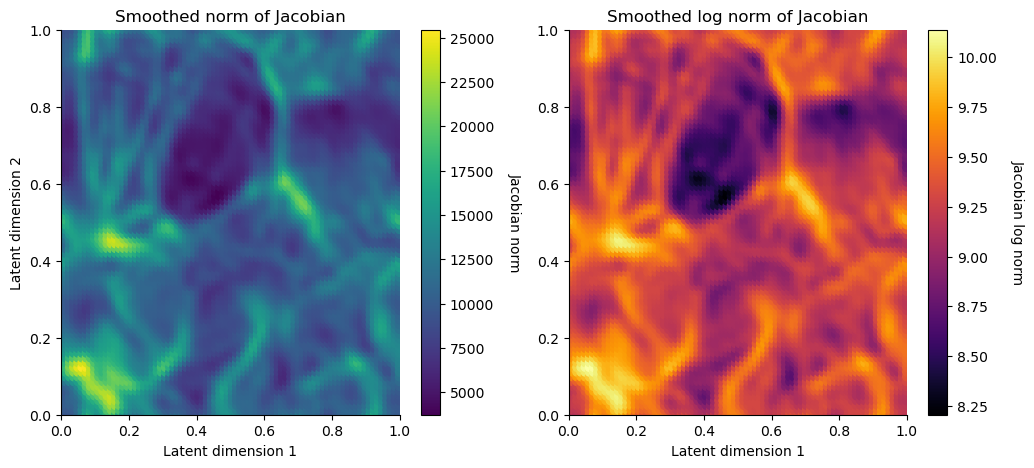

In [57]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
g1 = axs[0].scatter(plt_unif_x,plt_unif_y,c=plt_smooth_norms,cmap='viridis')
g2 = axs[1].scatter(plt_unif_x,plt_unif_y,c=plt_smoothed_log_norms,cmap='inferno')

axs[0].set_title('Smoothed norm of Jacobian')
axs[1].set_title('Smoothed log norm of Jacobian')
for ax in axs:
    ax.spines[['right','top']].set_visible(False)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel("Latent dimension 1")
    ax.set_rasterization_zorder(0)
axs[0].set_ylabel("Latent dimension 2")
cb1 = plt.colorbar(g1,ax=axs[0])
cb2  = plt.colorbar(g2,ax=axs[1])

cb1.set_label("Jacobian norm",rotation=270,labelpad=20)
cb2.set_label("Jacobian log norm",rotation=270,labelpad=20)
plt.show()
plt.close()